In [27]:
import matplotlib.pyplot as plt
import glob
import os
import argparse
import numpy as np
import pandas as pd
import significantdigits as sd

In [13]:
def parse_fmri_mat_files(base):
    unique_subjects ={os.path.basename(path) for path in glob.glob(f'{base}/*/*')}
    matfiles = { subject : [] for subject in unique_subjects}
    repetitions = { os.path.basename(r) for r in glob.glob(f'{base}/*') }

    for subject in unique_subjects:
        unique_matfile = { os.path.basename(matfile) for matfile in glob.glob(f'{base}/*/{subject}/*') }
        matfiles[subject] = {matfile : [os.path.join(base, repetition, subject, matfile) for repetition in repetitions] for matfile in unique_matfile }
        
    return matfiles

In [14]:
results_mca=parse_fmri_mat_files('results_mc/mca')


In [15]:
results_6param=parse_fmri_mat_files('results_mc/6rigidparams')


In [16]:

def load_mat_file(mat_file):
    return np.loadtxt(mat_file)

In [125]:

larger_movement = {}

for subject, matfiles in results_6param.items():
    larger_movement[subject] = {}

    for matfile, matrix_list in matfiles.items():

        for i in range(1, 11):
            
            m = np.array(load_mat_file(f'{matrix_list[i-1]}'))

            if m[1, 0] > 2 or m[1, 1] > 2 or m[1, 2] > 2:
                # If there is a larger movement, append the array to the list
              
                if matfile not in larger_movement[subject]:
                    larger_movement[subject][matfile] = []
               

                larger_movement[subject][matfile].append({'array': m.tolist(), 'condition': matrix_list[i-1].split('/')[2]})
 

larger_movement = {k: v for k, v in larger_movement.items() if v}


In [126]:
larger_movement

{'sub-0025486': {'MAT_0029': [{'array': [[-0.023082179299176435,
      0.0034550058773376658,
      -0.0021540139007510907],
     [-0.650616, -1.287285, 2.064614]],
    'condition': '1'},
   {'array': [[-0.023102197174939176,
      0.003451006628404472,
      -0.002054013543518288],
     [-0.634874, -1.300312, 2.075363]],
    'condition': '4'},
   {'array': [[-0.023145209065900788,
      0.003445007685007219,
      -0.0023720168994927552],
     [-0.668594, -1.266527, 2.072303]],
    'condition': '3'},
   {'array': [[-0.023020172359582338,
      0.0034530055364472966,
      -0.0022010140538903608],
     [-0.650804, -1.276133, 2.059657]],
    'condition': '6'},
   {'array': [[-0.022843103259902436,
      0.003277006282297453,
      -0.002647017640908804],
     [-0.677464, -1.217504, 2.014262]],
    'condition': '10'},
   {'array': [[-0.022969162536612405,
      0.0034580069022264715,
      -0.002009013369241344],
     [-0.631132, -1.297924, 2.052556]],
    'condition': '2'},
   {'array':

In [35]:
# !pip3 install nilearn
# !pip3 install nibabel
# !pip3 install tqdm
import glob
from PIL import Image
from nilearn import plotting
import os
import nibabel as nib
import tqdm

def make_gifs(base, save_filepath,timepoint):
    #subs = [x.split('.')[0] for x in os.listdir(f'{base}/2') if 'gz' in x]
    sub='sub-0027204'
    #print(subs)
    #for sub in subs:
        # files = glob.glob(f"/home/ine5/projects/rrg-glatard/brainhack-2023-linear-registration/results/mca/*/{sub}.nii.gz")
    if os.path.isdir(f'{save_filepath}/gifs_mcflirt/{sub}'): print('already exists')
    else: 
        os.makedirs(f'{save_filepath}/gifs_mcflirt/{sub}', exist_ok=True)
        print('make a directory')
    for i in tqdm.tqdm(range(1,11)):
        try:
            img = nib.load(f'{base}/{i}/{sub}.nii.gz')
            mid_slice_x_fmri = img.get_fdata()[25,:, :, timepoint]  # x = 39, t = 51
            # img = nib.Nifti1Image(mid_slice_x_fmri[:,:,np.newaxis], img.affine)
            axes = plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
            plt.savefig(f'{save_filepath}/gifs_mcflirt/{sub}/{i}.png')
        except Exception as e:
            print(e)
            continue
        # plotting.plot_anat(img, cut_coords=(0,0,0), title=f'{i}', dim=-0.5, output_file=f'{save_filepath}/gifs_mcflirt/{sub}/{i}.png')
    frames = [Image.open(f'{save_filepath}/gifs_mcflirt/{sub}/{image}') for image in os.listdir(f'{save_filepath}/gifs_mcflirt/{sub}')]
    frame_one = frames[0]

    frame_one.save(f"{save_filepath}/gifs_mc_flirt_{sub}.gif", format="GIF", append_images=frames,save_all=True, duration=200, loop=0)
        

already exists


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


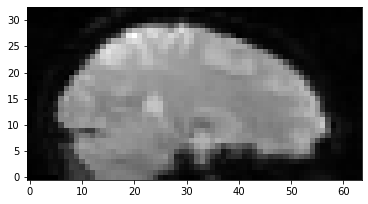

In [36]:
make_gifs('results_mc/mca','results_mc',225)

In [133]:
import significantdigits
import nilearn.plotting


paths = [os.path.join('results_mc', 'mca', str(i), 'sub-0027204.nii.gz') for i in range(1,11)]
images = np.array([nib.load(img).get_fdata()[...,225] for img in paths])
sig = significantdigits.significant_digits(images, reference=np.mean(images, axis=0), basis=2, dtype=np.float32)
image = nib.Nifti1Image(np.where(sig>0, sig, 0), np.eye(4))


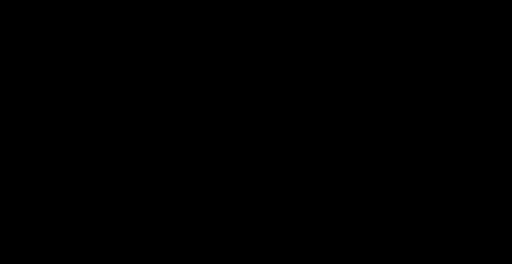
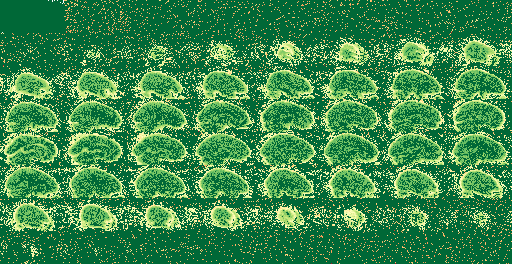

In [134]:
nilearn.plotting.view_img(image, cmap='RdYlGn',  vmax=12, symmetric_cmap=False, black_bg=True, bg_img=None)


In [136]:
result=results_6param['sub-0027204']['MAT_0225']
mat_array = np.array([load_mat_file(f'{m}') for m in result])
#print(mat_array)
mean=np.mean(mat_array, axis=0)
std = np.std(mat_array, axis=0, dtype=np.float64)
sig= sd.significant_digits(mat_array,  reference=mean)
print('mean value of the matfiles for 10 repetition= \n ', mean)
print('std value of the matfiles for 10 repetition= \n ', std)
print('sig value of the matfiles for 10 repetition= \n', sig)

mean value of the matfiles for 10 repetition= 
  [[-3.47692506e-02 -5.06272188e-03  1.20831584e-03]
 [ 6.26336900e-01 -1.34065990e+00  3.86721010e+00]]
std value of the matfiles for 10 repetition= 
  [[7.01394428e-05 1.07638296e-04 6.69276806e-05]
 [7.74090561e-03 7.63424357e-03 1.35596188e-02]]
sig value of the matfiles for 10 repetition= 
 [[7.1141644  3.71644398 2.33504489]
 [4.49908682 5.61703648 6.31662683]]


In [96]:
# Specify the file path of your CSV file
csv_file_path ='results_mc/datas/df_sd.csv'

# Read the CSV file into a DataFrame
df_sd = pd.read_csv(csv_file_path)
# Specify the file path of your CSV file
csv_file_path ='results_mc/datas/df_sig.csv'

# Read the CSV file into a DataFrame
df_sig = pd.read_csv(csv_file_path)
# Specify the file path of your CSV file
csv_file_path ='results_mc/datas/df_mean.csv'

# Read the CSV file into a DataFrame
df_mean = pd.read_csv(csv_file_path)
